In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import linregress
import ast

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import scipy.stats as st
from scipy.stats import uniform, randint
from sklearn.metrics import recall_score, make_scorer, f1_score



In [136]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

Doing the same as the previous notebook but I will add these features

- Form. W/D/L in the last 5 games
- Time passed sinc the last match they played
- Half time score in the last 3 games
- Home v Away Season performance 

In [137]:
matchesSpain = pd.read_csv('data/matches_Spain.csv')
matchesItaly = pd.read_csv('data/matches_Italy.csv')
matchesGermany = pd.read_csv('data/matches_Germany.csv')
matchesFrance= pd.read_csv('data/matches_France.csv')
matchesEngland = pd.read_csv('data/matches_England.csv')

matches=pd.concat((matchesEngland,matchesSpain,matchesItaly,matchesGermany,matchesFrance), axis=0)

Dropping columns not needed for this phase

In [138]:
matches.drop(['status','duration','team1.scoreET','team1.scoreP','team1.hasFormation','team2.scoreET','team2.scoreP','team2.hasFormation'],
             axis=1, inplace=True)

In [139]:
matches.drop(['roundId','seasonId'],
             axis=1, inplace=True)

In [140]:
matches.drop(['teamsData', 'venue', 
                'date', 'referees', 'team1.coachId', 
                'team1.formation', 'team1.formation.bench', 'team1.formation.lineup',
                'team1.formation.substitutions', 'team2.coachId',
                'team2.formation', 'team2.formation.bench', 'team2.formation.lineup',
                'team2.formation.substitutions'],
            axis=1, inplace=True)


Sorting by date

In [141]:
matches=matches.sort_values(by=['dateutc','wyId']).reset_index(drop=True)

Mapping teamId to teamName

In [142]:
teams=pd.read_csv('data/teams.csv')
team_mapping=teams.set_index('wyId')['name'].to_dict()

In [143]:
matches['team1.teamId']=matches['team1.teamId'].map(team_mapping)
matches['team2.teamId']=matches['team2.teamId'].map(team_mapping)
matches['winner']=matches['winner'].map(team_mapping)

matches.rename(columns={'team1.teamId':'team1.teamName','team2.teamId':'team2.teamName'}, inplace=True)

#### Restructuring matches table so that it is more easier to identify the home and away teams

In [144]:
home_teams1 = matches[matches['team1.side'] == 'home'].copy()
home_teams1 = home_teams1[['team1.teamName', 'team1.score', 'team1.scoreHT']]
home_teams1.columns=[ 'home.teamName', 'home.score', 'home.scoreHT']

home_teams2 = matches[matches['team2.side'] == 'home'].copy()
home_teams2 = home_teams2[['team2.teamName', 'team2.score', 'team2.scoreHT']]
home_teams2.columns = ['home.teamName', 'home.score', 'home.scoreHT']

home_teams=pd.concat([home_teams1, home_teams2], axis=0).sort_index()



In [145]:
away_teams1 = matches[matches['team1.side'] == 'away'].copy()
away_teams1 = away_teams1[['team1.teamName', 'team1.score', 'team1.scoreHT']]
away_teams1.columns=['away.teamName', 'away.score', 'away.scoreHT']

away_teams2 = matches[matches['team2.side'] == 'away'].copy()
away_teams2 = away_teams2[['team2.teamName', 'team2.score', 'team2.scoreHT']]
away_teams2.columns = ['away.teamName', 'away.score', 'away.scoreHT']

away_teams=pd.concat([away_teams1, away_teams2], axis=0).sort_index()

In [146]:
match_cols = matches[['competitionId','gameweek','wyId', 'dateutc', 'winner', 'label']]

In [147]:
matches = pd.concat([match_cols , home_teams, away_teams], axis = 1)

#### Adding a column for wins, draws, loses

In [148]:
# Define win, loss, draw for home teams
matches['home.win'] = (matches['winner'] == matches['home.teamName']).astype(int)
matches['home.loss'] = (matches['winner'] == matches['away.teamName']).astype(int)
matches['home.draw'] = matches['winner'].isna().astype(int)

# Define win, loss, draw for away teams
matches['away.win'] = (matches['winner'] == matches['away.teamName']).astype(int)
matches['away.loss'] = (matches['winner'] == matches['home.teamName']).astype(int)
matches['away.draw'] = matches['winner'].isna().astype(int)

In [149]:
matches.tail()

,competitionId,gameweek,wyId,dateutc,winner,label,home.teamName,home.score,home.scoreHT,away.teamName,away.score,away.scoreHT,home.win,home.loss,home.draw,away.win,away.loss,away.draw
1821,524,38,2576337,2018-05-20 16:00:00,SPAL,"SPAL - Sampdoria, 3 - 1",SPAL,3,1,Sampdoria,1,0,1,0,0,0,1,0
1822,795,38,2565925,2018-05-20 16:30:00,NaN,"Atl\u00e9tico Madrid - Eibar, 2 - 2",Atl\u00e9tico Madrid,2,1,Eibar,2,1,0,0,1,0,0,1
1823,795,38,2565922,2018-05-20 18:45:00,Barcelona,"Barcelona - Real Sociedad, 1 - 0",Barcelona,1,0,Real Sociedad,0,0,1,0,0,0,1,0
1824,524,38,2576335,2018-05-20 18:45:00,Internazionale,"Lazio - Internazionale, 2 - 3",Lazio,2,2,Internazionale,3,1,0,1,0,1,0,0
1825,524,38,2576336,2018-05-20 18:45:00,Roma,"Sassuolo - Roma, 0 - 1",Sassuolo,0,0,Roma,1,1,0,1,0,1,0,0


In [150]:
##getting wins, draws, and losses since start of season when a team is at HOME
matches['home.wins_home'] = matches.groupby('home.teamName')['home.win'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

matches['home.draws_home'] = matches.groupby('home.teamName')['home.draw'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

matches['home.losses_home'] = matches.groupby('home.teamName')['home.loss'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

##getting wins, draws, and losses since start of season when a team is at AWAY

matches['away.wins_away'] = matches.groupby('away.teamName')['away.win'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

matches['away.draws_away'] = matches.groupby('away.teamName')['away.draw'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

matches['away.losses_away'] = matches.groupby('away.teamName')['away.loss'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

In [151]:
homeMatches=matches[['dateutc','wyId', 'home.teamName',
                     'home.score', 'away.score', 'home.scoreHT',
                     'away.scoreHT', 'home.win', 'home.loss', 'home.draw']
                   ]

In [152]:
homeMatches[homeMatches['home.teamName']=='Barcelona']

,dateutc,wyId,home.teamName,home.score,away.score,home.scoreHT,away.scoreHT,home.win,home.loss,home.draw
66,2017-08-20 18:15:00,2565554,Barcelona,2,0,2,0,1,0,0
154,2017-09-09 18:45:00,2565577,Barcelona,5,0,2,0,1,0,0
231,2017-09-19 20:00:00,2565592,Barcelona,6,1,2,0,1,0,0
341,2017-10-01 14:15:00,2565615,Barcelona,3,0,0,0,1,0,0
425,2017-10-21 18:45:00,2565629,Barcelona,2,0,1,0,1,0,0
532,2017-11-04 19:45:00,2565653,Barcelona,2,1,1,0,1,0,0
680,2017-12-02 12:00:00,2565681,Barcelona,2,2,1,1,0,0,1
835,2017-12-17 19:45:00,2565704,Barcelona,4,0,2,0,1,0,0
935,2018-01-07 15:15:00,2565718,Barcelona,3,0,2,0,1,0,0
1075,2018-01-28 19:45:00,2565754,Barcelona,2,1,0,1,1,0,0


In [153]:
homeMatches=homeMatches.rename(columns={
                            'home.teamName':'teamName',
                            'home.score':'numGoals',
                            'away.score':'numConceded',
                            'home.scoreHT':'numGoalsHT',
                            'away.scoreHT':'numConcededHT',
                            'home.win':'win', 
                            'home.loss':'loss',
                            'home.draw':'draw'}
                              )

In [154]:
awayMatches=matches[['dateutc','wyId', 'away.teamName',
                     'away.score', 'home.score', 'away.scoreHT',
                     'home.scoreHT', 'away.win', 'away.loss', 'away.draw']
                   ]

In [155]:
awayMatches=awayMatches.rename(columns={
                            'away.teamName':'teamName',
                            'away.score':'numGoals',
                            'home.score':'numConceded',
                            'away.scoreHT':'numGoalsHT',
                            'home.scoreHT':'numConcededHT',
                            'away.win':'win', 
                            'away.loss':'loss',
                            'away.draw':'draw'}
                              )
                              

In [156]:
#tidying up the matches table because the data is now captured in home and away matches

matches.drop(['home.win', 'home.loss', 'home.draw',
              'away.win', 'away.loss', 'away.draw',
              'home.score', 'home.scoreHT',
              'away.score', 'away.scoreHT'
              ], axis=1, inplace=True)


In [157]:
disjointedMatches=pd.concat([homeMatches,awayMatches],axis=0).sort_values(by=['dateutc','wyId'])

In [158]:
disjointedMatches

,dateutc,wyId,teamName,numGoals,numConceded,numGoalsHT,numConcededHT,win,loss,draw
0,2017-08-04 18:45:00,2500691,Monaco,3,2,1,1,1,0,0
0,2017-08-04 18:45:00,2500691,Toulouse,2,3,1,1,0,1,0
1,2017-08-05 15:15:00,2500693,PSG,2,0,1,0,1,0,0
1,2017-08-05 15:15:00,2500693,Amiens SC,0,2,0,1,0,1,0
2,2017-08-05 18:00:00,2500688,Olympique Lyonnais,4,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1823,2018-05-20 18:45:00,2565922,Real Sociedad,0,1,0,0,0,1,0
1824,2018-05-20 18:45:00,2576335,Lazio,2,3,2,1,0,1,0
1824,2018-05-20 18:45:00,2576335,Internazionale,3,2,1,2,1,0,0
1825,2018-05-20 18:45:00,2576336,Sassuolo,0,1,0,1,0,1,0


In [159]:
# Calculate cumulative mean excluding the current row's goals
disjointedMatches['GoalsPerGame'] = disjointedMatches.groupby('teamName')['numGoals'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

# Calculate rolling mean over the last 3 rows excluding the current row's goals
disjointedMatches['GoalsPerGame_last3'] = disjointedMatches.groupby('teamName')['numGoals'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

# Calculate cumulative mean excluding the current row's goals
disjointedMatches['ConcededPerGame'] = disjointedMatches.groupby('teamName')['numConceded'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

# Calculate rolling mean over the last 3 rows excluding the current row's goals
disjointedMatches['ConcededPerGame_last3'] = disjointedMatches.groupby('teamName')['numConceded'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

In [160]:
#Halftime goals scored and conceded

# Calculate cumulative mean excluding the current row's goals
disjointedMatches['GoalsHTPerGame'] = disjointedMatches.groupby('teamName')['numGoalsHT'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

# Calculate rolling mean over the last 3 rows excluding the current row's goals
disjointedMatches['GoalsHTPerGame_last3'] = disjointedMatches.groupby('teamName')['numGoalsHT'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

# Calculate cumulative mean excluding the current row's goals
disjointedMatches['ConcededHTPerGame'] = disjointedMatches.groupby('teamName')['numConcededHT'].transform(
    lambda x: x.shift(1).cumsum() / x.shift(1).expanding().count()
)

# Calculate rolling mean over the last 3 rows excluding the current row's goals
disjointedMatches['ConcededHTPerGame_last3'] = disjointedMatches.groupby('teamName')['numConcededHT'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)


In [161]:
##getting total(home and away) running wins, draws, and losses in a rolling 3 match window
disjointedMatches['wins_last3'] = disjointedMatches.groupby('teamName')['win'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()
)

disjointedMatches['draws_last3'] = disjointedMatches.groupby('teamName')['draw'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()
)

disjointedMatches['losses_last3'] = disjointedMatches.groupby('teamName')['loss'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).sum()
)


In [162]:
##getting the time elapsed since the previous match
disjointedMatches['dateutc']=pd.to_datetime(disjointedMatches.pop('dateutc'))

disjointedMatches['time_since_prev'] = disjointedMatches.groupby('teamName')['dateutc'].transform(
    lambda x: x - x.shift(1)
)

disjointedMatches['time_since_prev']=disjointedMatches['time_since_prev'].dt.total_seconds()/(60*60*24)



Joining features relating to the home team back to the matches table

In [163]:
matches=matches.merge(
    disjointedMatches, 
    how='left', 
    left_on=['wyId','home.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'time_since_prev':'home.time_since_prev',
                  'GoalsPerGame':'home.GoalsPerGame',
                  'GoalsPerGame_last3':'home.GoalsPerGame_last3',
                  'ConcededPerGame':'home.ConcededPerGame',
                  'ConcededPerGame_last3':'home.ConcededPerGame_last3',
                  'GoalsHTPerGame':'home.GoalsHTPerGame',
                  'GoalsHTPerGame_last3':'home.GoalsHTPerGame_last3',
                  'ConcededHTPerGame':'home.ConcededHTPerGame',
                  'ConcededHTPerGame_last3':'home.ConcededHTPerGame_last3',
                  'wins_last3':'home.wins_last3',
                  'draws_last3':'home.draws_last3',
                  'losses_last3':'home.losses_last3'                  
                 })

matches.drop(['dateutc_y','teamName','numGoals',
             'win','loss','draw',
             'numGoals','numConceded','numGoalsHT','numConcededHT'
             ], axis=1, inplace=True)


Joining features relating to the home team back to the matches table

In [164]:
matches=matches.merge(
    disjointedMatches, 
    how='left', 
    left_on=['wyId','away.teamName'], 
    right_on=['wyId','teamName'],
    suffixes=('','_y')
).rename(columns={'time_since_prev':'away.time_since_prev',
                  'GoalsPerGame':'away.GoalsPerGame',
                  'GoalsPerGame_last3':'away.GoalsPerGame_last3',
                  'ConcededPerGame':'away.ConcededPerGame',
                  'ConcededPerGame_last3':'away.ConcededPerGame_last3',
                  'GoalsHTPerGame':'away.GoalsHTPerGame',
                  'GoalsHTPerGame_last3':'away.GoalsHTPerGame_last3',
                  'ConcededHTPerGame':'away.ConcededHTPerGame',
                  'ConcededHTPerGame_last3':'away.ConcededHTPerGame_last3',
                  'wins_last3':'away.wins_last3',
                  'draws_last3':'away.draws_last3',
                  'losses_last3':'away.losses_last3'                  
                 })

matches.drop(['dateutc_y','teamName','numGoals',
             'win','loss','draw',
             'numGoals','numConceded','numGoalsHT','numConcededHT'
             ], axis=1, inplace=True)




Columns no longer needed

### updating competition id with the actual competition

In [165]:
competitions= pd.read_csv('data/competitions.csv')
comp_mapping=competitions.set_index('wyId')['name'].to_dict()


In [166]:
matches['competition']=matches['competitionId'].map(comp_mapping)
matches.drop(columns=['competitionId'], inplace=True)

#### Adding the column that will be passed in my model as the label

In [167]:
matches = matches.copy()

matches['result'] = np.where(matches['winner'] == matches['home.teamName'], 'H',
                        np.where(matches['winner'] == matches['away.teamName'], 'A', 'D'))

In [168]:
#wyId, date, winner and match labels (label here is the desciption of the match) are no longer needed
matches.drop(columns=['wyId', 'dateutc', 'winner', 'label', 'home.teamName', 'away.teamName'], inplace=True)

In [169]:
label_encoder = LabelEncoder()
matches['label'] = label_encoder.fit_transform(matches['result'])


In [170]:
#filtering only where gameweek is 4th or more. This is because I am using the results from the last 3 games in a lot of my features. 
matches=matches[matches['gameweek']>=4]

In [171]:
features=matches.copy()

Training data is all data not in the English division

In [172]:
train=matches[~(matches['competition'].str.contains("English"))]

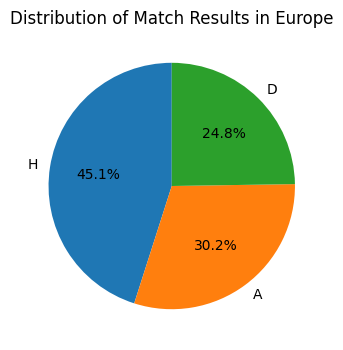

In [173]:
# Calculate value counts for 'result' column
result_counts = train['result'].value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in Europe")
plt.show()




Test data is all data in the English division

In [174]:
test=matches[(matches['competition'].str.contains("English"))]


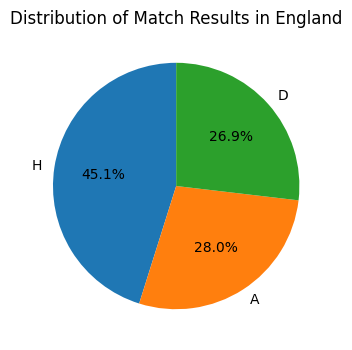

In [175]:
# Calculate value counts for 'result' column
result_counts = test['result'].value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England")
plt.show()


In [176]:
train=train.copy()
test=test.copy()
train.drop(columns=['competition','gameweek', 'result'], inplace=True)
test.drop(columns=['competition','gameweek', 'result'], inplace=True)

## Building my Model

In [177]:
# Step 1: Prepare data and label encode
# Step 2: Split the data
X_train = train.drop(columns=['label'])
y_train= train['label']

X_test= test.drop(columns=['label'])
y_test= test['label']

In [178]:
# Step 3 Scale the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### RandomForest

In [179]:
# Step 4: Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [180]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.47


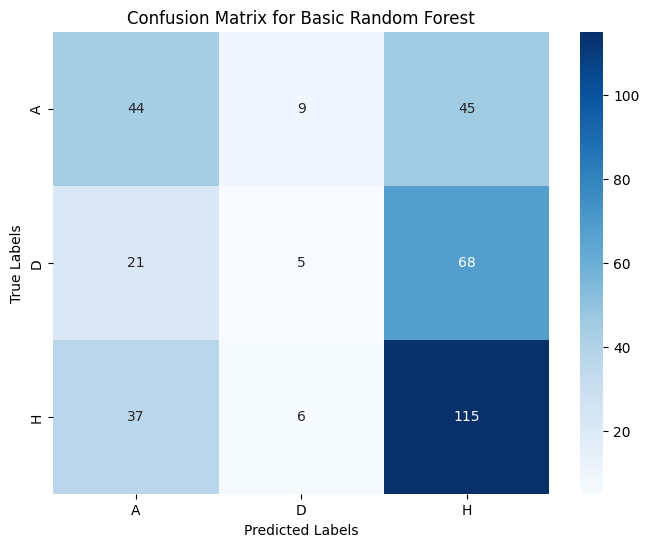

Classification Report:
               precision    recall  f1-score   support

           A       0.43      0.45      0.44        98
           D       0.25      0.05      0.09        94
           H       0.50      0.73      0.60       158

    accuracy                           0.47       350
   macro avg       0.40      0.41      0.37       350
weighted avg       0.42      0.47      0.42       350



In [181]:

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Basic Random Forest")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)


In [484]:
#%%time
##Took 10 minutes to run with all the extra features
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'criterion': ['gini', 'entropy']
#}

#grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
#grid_search.fit(X_train, y_train)
#print(f'Best Parameters: {grid_search.best_params_}')

In [182]:
%%time
#Wall time: 1min 23s

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_iter=20)
random_search.fit(X_train, y_train)
print(f'Best Parameters: {random_search.best_params_}')

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}
CPU times: user 2min 12s, sys: 161 ms, total: 2min 12s
Wall time: 2min 12s


In [183]:
model = RandomForestClassifier(
    criterion='gini',
    max_depth=30,
    min_samples_leaf=4,
    min_samples_split=5,
    n_estimators=500,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500, random_state=42)

In [184]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 0.49


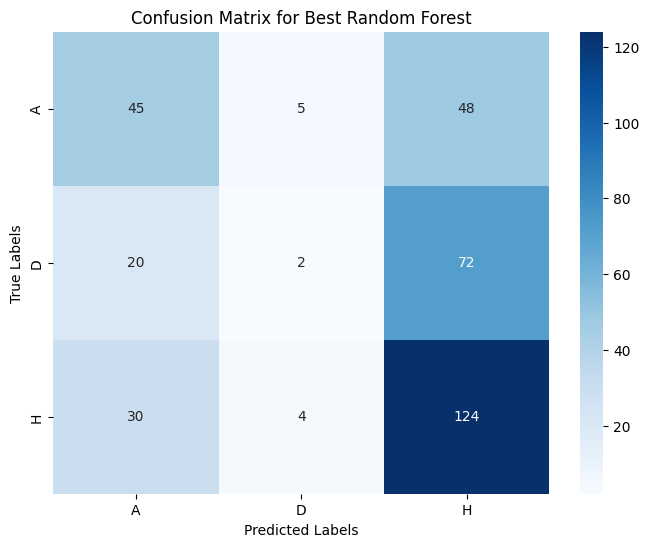

Classification Report:
               precision    recall  f1-score   support

           A       0.47      0.46      0.47        98
           D       0.18      0.02      0.04        94
           H       0.51      0.78      0.62       158

    accuracy                           0.49       350
   macro avg       0.39      0.42      0.37       350
weighted avg       0.41      0.49      0.42       350



In [185]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Best Random Forest")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

### XGBoost

In [186]:
# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [187]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.35      0.39        98
           1       0.32      0.19      0.24        94
           2       0.53      0.72      0.61       158

    accuracy                           0.47       350
   macro avg       0.43      0.42      0.41       350
weighted avg       0.45      0.47      0.45       350



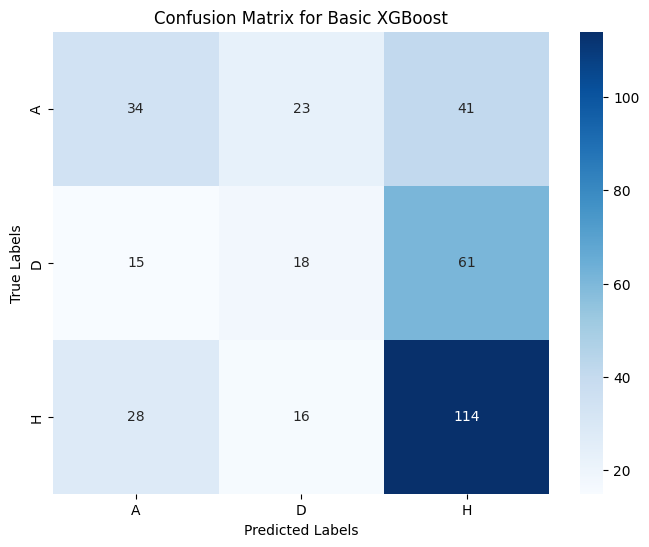

Classification Report:
               precision    recall  f1-score   support

           A       0.44      0.35      0.39        98
           D       0.32      0.19      0.24        94
           H       0.53      0.72      0.61       158

    accuracy                           0.47       350
   macro avg       0.43      0.42      0.41       350
weighted avg       0.45      0.47      0.45       350



In [189]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Basic XGBoost")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

In [236]:
uniform(0.5, 0.5)

In [238]:
%%time



# Define the model
model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': randint(100, 1000),          # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),         # Learning rate
    'max_depth': randint(3, 10),                 # Max depth of tree
    'min_child_weight': randint(1, 10),          # Min child weight
    'subsample': uniform(0, 1),              # Fraction of samples used for each tree
    'colsample_bytree': uniform(0, 1),       # Fraction of features for each tree
    'gamma': uniform(0, 1),                      # Gamma (min loss reduction)
    'reg_alpha': uniform(0, 1),                  # L1 regularization term
    'reg_lambda': uniform(0, 1),                 # L2 regularization term
}

# Define the recall scorer for multiclass classification
#f1_scorer = make_scorer(f1_score, average='weighted')

# Initialize RandomizedSearchCV with the updated scorer
random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                   n_iter=20, cv=5, scoring='accuracy',
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters
print(f'Best Parameters: {random_search.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'colsample_bytree': 0.31171107608941095, 'gamma': 0.5200680211778108, 'learning_rate': 0.1740130838029839, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 829, 'reg_alpha': 0.44975413336976566, 'reg_lambda': 0.3951502360018144, 'subsample': 0.9266588657937942}
CPU times: user 5.11 s, sys: 243 ms, total: 5.36 s
Wall time: 21.4 s


In [239]:
# Predict and evaluate
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.38      0.41        98
           1       0.22      0.09      0.12        94
           2       0.52      0.76      0.62       158

    accuracy                           0.47       350
   macro avg       0.39      0.41      0.38       350
weighted avg       0.42      0.47      0.43       350



In [220]:
# Best hyperparameters from RandomizedSearchCV
best_params = {
    'colsample_bytree': 0.74,
    'gamma': 0.985,
    'learning_rate': 0.08,
    'max_depth': 6,
    'min_child_weight': 7,
    'n_estimators': 302,
    'reg_alpha': 0.37,
    'reg_lambda': 0.24,
    'subsample': 0.90
}

model = xgb.XGBClassifier(**best_params)

In [221]:
# Train the model
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.74, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.985, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=302, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [222]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.41      0.44        98
           1       0.32      0.14      0.19        94
           2       0.53      0.75      0.62       158

    accuracy                           0.49       350
   macro avg       0.44      0.43      0.42       350
weighted avg       0.46      0.49      0.46       350



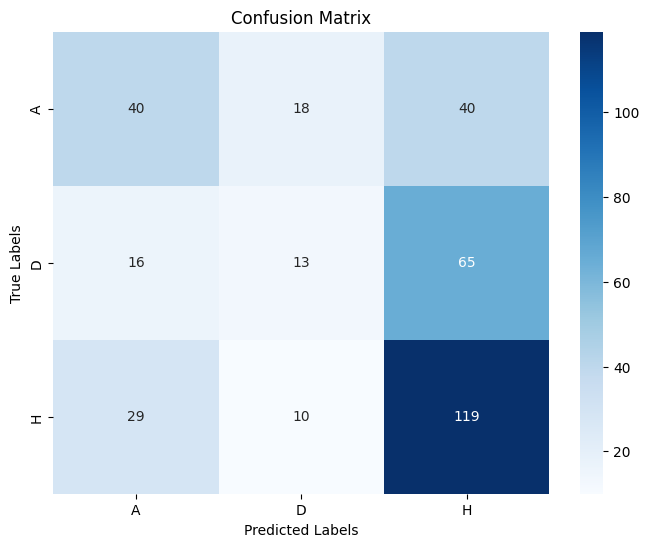

Classification Report:
               precision    recall  f1-score   support

           A       0.47      0.41      0.44        98
           D       0.32      0.14      0.19        94
           H       0.53      0.75      0.62       158

    accuracy                           0.49       350
   macro avg       0.44      0.43      0.42       350
weighted avg       0.46      0.49      0.46       350



In [223]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

### Feature Importance

In [195]:
X_train

array([[ 2.26874937, -1.40453359, -1.36632368, ..., -1.00349944,
        -1.20220932, -0.3847221 ],
       [-1.85731868, -1.40453359,  2.90113241, ...,  0.35046072,
        -1.20220932, -0.12947479],
       [-1.85731868, -1.40453359,  2.90113241, ..., -1.00349944,
         1.03551643, -0.13219018],
       ...,
       [ 1.58107136, -0.38535804, -1.36632368, ..., -1.00349944,
        -0.08334644,  0.18822666],
       [ 0.20571535,  0.29409232, -0.41800011, ..., -1.00349944,
         1.03551643,  0.12848793],
       [-0.94041467,  0.97354269,  0.29324257, ...,  0.35046072,
        -1.20220932, -0.13219018]])

In [196]:
train_features=train.drop(columns=['label'])

In [197]:
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'feature': train_features.columns, 'importance': feature_importances})
features_df = features_df.sort_values(by='importance', ascending=False)
print(features_df)

                         feature  importance
18             away.GoalsPerGame    0.056697
6              home.GoalsPerGame    0.047994
16             home.losses_last3    0.043870
5               away.losses_away    0.039307
10           home.GoalsHTPerGame    0.036322
22           away.GoalsHTPerGame    0.036126
20          away.ConcededPerGame    0.035392
3                 away.wins_away    0.033897
11     home.GoalsHTPerGame_last3    0.033435
9     home.ConcededPerGame_last3    0.032982
2               home.losses_home    0.032672
7        home.GoalsPerGame_last3    0.032522
12        home.ConcededHTPerGame    0.032121
24        away.ConcededHTPerGame    0.032108
8           home.ConcededPerGame    0.031641
26               away.wins_last3    0.031378
13  home.ConcededHTPerGame_last3    0.031288
14               home.wins_last3    0.030938
28             away.losses_last3    0.030760
0                 home.wins_home    0.030463
19       away.GoalsPerGame_last3    0.030318
25  away.C